<a href="https://colab.research.google.com/github/al3jandroR/nba_predictions/blob/colab/nba_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install nba_api

Written by Alex Rodriguez and Zach Guida<br>
CS345: Introduction to Machine Learning<br>
Nikhil Krishwasamy

 &nbsp; &nbsp; &nbsp; &nbsp;This project highlights the functionality of the random forest classifier alongside proper data collection techniques. Our design is meant to process data from recent NBA games and provide predictions for future games. The model is based on a number of features provided by an API through a github repository built by Swar Patel under the MIT license. 

In [4]:
from nba_api.stats.endpoints import teamgamelog, scoreboardv2, PlayerProfileV2, commonteamroster, GameRotation
from nba_api.stats.static import teams

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif


from datetime import datetime, timedelta
import numpy as np
from pytz import timezone
import pandas as pd
import matplotlib.pyplot as plt
import time

In [5]:
nba_teams = teams.get_teams()
teams_df = pd.DataFrame(nba_teams)

 &nbsp; &nbsp; &nbsp; &nbsp;The NBA_api interface provides significant detail on games, seasons, players, and team data. Accessed through calls to the NBA database it can be an arduous task to collect all of the data at once. To cirumvent this issue our data has been saved to a static file prodived alongside this notebook which should be used for running the simulation. All that is necessary for this is to make sure the two files are in the same directory. 

 &nbsp; &nbsp; &nbsp; &nbsp;The model we built uses a small subset of the data provided through the API. Our call returns ['GAME_DATE', 'WL', 'PTS', 'OREB', 'DREB', 'FG_PCT', 'AST', 'TOV', 'STL', 'BLK'] defined in the get_team_stats method below. We process these raw stats into useful metrics, which are passed along to the rest of the system. 

In [6]:
# Helper function to avoid api rate limits
def safe_request(func, *args, **kwargs):
    while True:
        try:
            return func(*args, **kwargs)
        except Exception as e:
            print(f"Error: {e}. Retrying in 5 seconds...")
            time.sleep(5)

def get_team_id(abbr):
    team = teams_df[teams_df['abbreviation'] == abbr.upper()]
    if not team.empty:
        return team.iloc[0]['id']
    else:
        raise ValueError(f"Team abbreviation '{abbr}' not found.")

def get_team_abbr(team_id):
    team = teams_df[teams_df['id'] == team_id]
    if not team.empty:
        return team.iloc[0]['abbreviation']
    else:
        raise ValueError(f"No team found for ID: {team_id}")

def get_team_name(team_id):
    team = teams_df[teams_df['id'] == team_id]
    if not team.empty:
        return team.iloc[0]['full_name']
    else:
        raise ValueError(f"No team found for ID: {team_id}")

def get_team_stats(team_id, season, n=5):
    log = safe_request(teamgamelog.TeamGameLog, team_id=team_id, season=season)
    df = log.get_data_frames()[0]
    df = df[['GAME_ID','GAME_DATE', 'MATCHUP', 'WL', 'PTS', 'OREB', 'DREB', 'FG_PCT', 'AST', 'TOV', 'STL', 'BLK']].copy()

    df['SEASON'] = season
    df['TEAM'] = get_team_name(team_id)
    df['HOME'] = df['MATCHUP'].str.contains('vs.').astype(int)
    df['WIN'] = df['WL'].apply(lambda x: 1 if x == 'W' else 0)
    df['STREAK'] = df['WIN'].rolling(window=n).sum().shift(-1).fillna(0)
    df['OPP_ABBR'] = df['MATCHUP'].str.extract(r'@ (\w+)|vs\. (\w+)').bfill(axis=1).iloc[:, 0]

    # avg stats from last 5 games
    rolling_features = ['PTS', 'OREB', 'DREB', 'FG_PCT', 'AST', 'TOV', 'STL', 'BLK']
    for col in rolling_features:
        df[f'{col}_AVG'] = df[col].rolling(window=n).mean().shift(-1)

    df['DEFENSE_SCORE'] = df['STL_AVG'] + df['BLK_AVG'] + df['DREB_AVG']
    df['AST_TOV_RATIO'] = df['AST_AVG'] / (df['TOV_AVG'] + 1)
    df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'], format='%b %d, %Y')
    df['EFFICIENCY'] = df['FG_PCT_AVG'] * df['PTS_AVG']
    df['PREV_GAME_DATE'] = df['GAME_DATE'].shift(-1)
    df['DAYS_REST'] = (df['GAME_DATE'] - df['PREV_GAME_DATE']).dt.days.clip(lower=0)
    df['BACK_TO_BACK'] = (df['GAME_DATE'] - df['PREV_GAME_DATE']).dt.days.eq(1).astype(int)
    df['B2B_ROAD'] = (df['BACK_TO_BACK'] == 1) & (df['HOME'] == 0).astype(int)

    df['FORM_SCORE'] = df['AST_TOV_RATIO'] + df['DEFENSE_SCORE'] + df['EFFICIENCY']

    df = df.dropna().reset_index(drop=True)
    return df

def add_opponent_features(df):
    abbr_to_name = teams_df.set_index('abbreviation')['full_name'].to_dict()
    df['OPPONENT_TEAM'] = df['OPP_ABBR'].map(abbr_to_name)

    df['GAME_KEY'] = df['GAME_DATE'].astype(str) + "_" + df['TEAM']
    df['OPP_GAME_KEY'] = df['GAME_DATE'].astype(str) + "_" + df['OPPONENT_TEAM']

    eff_map = df.set_index('GAME_KEY')['EFFICIENCY'].to_dict()
    form_map = df.set_index('GAME_KEY')['FORM_SCORE'].to_dict()
    streak_map = df.set_index('GAME_KEY')['STREAK'].to_dict()

    df['OPP_EFFICIENCY'] = df['OPP_GAME_KEY'].map(eff_map).fillna(0)
    df['OPP_FORM_SCORE'] = df['OPP_GAME_KEY'].map(form_map).fillna(0)
    df['OPP_STREAK'] = df['OPP_GAME_KEY'].map(streak_map).fillna(0)

    df['NET_EFFICIENCY'] = df['EFFICIENCY'] - df['OPP_EFFICIENCY']
    df['NET_FORM_SCORE'] = df['FORM_SCORE'] - df['OPP_FORM_SCORE']
    df['NET_STREAK'] = df['STREAK'] - df['OPP_STREAK']

    df = df.dropna().reset_index(drop=True)
    return df

 &nbsp; &nbsp; &nbsp; &nbsp;Early on we recognized the potential difficulties presented by using the last n games as a predictor for the n+1 game. We considered a temporal organization and model that would preserve trends. This design fell short in processing time as the sheer number of games to process overwhelmed our computers. Instead, we used a rolling average of the last five games to predict the sixth. Pandas provides a method that scans the data in rolling five-line chunks averaging them and holding the sixth as the label. This meant we could effecvtively convert a regression probelm, predicting accurate scores, to a classfication problem, either a win or loss. A discussion on the most useful data will be included below but context for the features we built will be provided here. Each feature represents a score for the last five games for any given team. Defense score is a measure of how often a team steals the ball, blocks opponent shots, and rebounds off an offensive shot. This is a purely quantitative feature. An assist-turnover ratio expresses how well a team synergizes by comparing how often teamwork results in a benefit to the opposition. Efficiency measures the accuracy and frequency of shots made by a team. Form score combines all of these into a comprehensive metric. Presumably a higher score represents a better game. The opposition features method adds in the difference between opposition and team data to show how evenly matched the two teams were. The final feature to discuss is streak. This is a measure of the number of how many of a team's most recent games were won in succession.  

In [7]:
import os
def update_team_stats():
    seasons = ['2023-24', '2024-25']
    for season in seasons:
        for team in nba_teams:
            try:
                print(f"Loading {team['full_name']} - {season}...")
                team_data = get_team_stats(team['id'], season)
                team_data['Team'] = team['full_name']
                try:
                    os.remove(os.getcwd() + f'.\\Team_stats\\{team_data['Team'].iloc[0]}_stats.csv')
                except:
                    print('No file to delete')
                team_data.to_csv(f'./Team_stats/{team_data['Team'].iloc[0]}_stats.csv')
                time.sleep(1.5)
            except Exception as e:
                print(e)
                print(f"Skipping {team['full_name']} due to error")

In [8]:
def getPlayerImpact(playerId, season):
  player = playerId
  request = safe_request(PlayerProfileV2, player, 'Totals')
  df = request.get_data_frames()[0]
  df = df[df['SEASON_ID'].str.contains(f'{season}', case=False, na=False)]
  if df.empty:
    return 0
  if df['MIN'].iloc[0] < 500:
      return 0
  df['WEIGHTED_RANK_SCORE'] = (
  df['PTS']     * 2.0 +   # Scoring is key
  df['AST']     * 1.8 +   # Playmaking
  df['REB']     * 1.5 +   # Rebounding (OREB + DREB combined)
  df['STL']     * 1.5 +   # Defense
  df['BLK']     * 1.2 +   # Rim protection
  df['TOV']     * -2.0 +  # Turnovers are bad → negative weight
  df['FG_PCT'] * 1.2 +   # Shooting efficiency
  df['FG3_PCT'] * 0.8 +   # 3PT efficiency
  df['FT_PCT']  * 0.6   # Overall efficiency stat
  )
  return np.round(df['WEIGHTED_RANK_SCORE'].values[0] * (36/(df['MIN'].values[0])), 3)

def rankPlayers(seasonPlayed):
  playerImpacts = []
  players = get_all_rosters(seasonPlayed)
  
  for index, row in players.iterrows():
    id = row['PLAYER_ID']
    name = row['PLAYER']
    playerImpacts.append((name, id, getPlayerImpact(id, seasonPlayed)))
  playerImpacts.sort(key=lambda x: x[2], reverse=True)
  return pd.DataFrame(playerImpacts, columns=['Player Name', 'Id', 'Rank'])

def get_injuries():
    url = "https://www.espn.com/nba/injuries"
    tables = pd.read_html(url)

    all_injuries = []

    for table in tables:
        all_injuries.append(table)

    if not all_injuries:
        print("No injuries posted today.")
        return pd.DataFrame()

    df = pd.concat(all_injuries, ignore_index=True)
    df.columns = df.columns.str.upper()
    return df[['NAME', 'STATUS', 'EST. RETURN DATE']]

def get_team_injuries(team_abbr, injury_df):
    team_injuries = injury_df[injury_df['TEAM'] == team_abbr]

    if team_injuries.empty:
        return "None"

    return ", ".join(f"{row['NAME']} ({row['STATUS']})" for _, row in team_injuries.iterrows())

def get_all_rosters(seasonid):
    all_rosters = []

    for _, row in teams_df.iterrows():
        team_id = row['id']
        team_abbr = row['abbreviation']
        team_name = row['full_name']

        try:
            roster = commonteamroster.CommonTeamRoster(team_id=team_id, season=seasonid)
            roster_df = roster.get_data_frames()[0]
            roster_df['TEAM'] = team_abbr
            all_rosters.append(roster_df)
            time.sleep(1)
        except Exception as e:
            print(f"Skipping {team_name} due to error: {e}")

    final_roster = pd.concat(all_rosters, ignore_index=True)
    final_roster.columns = final_roster.columns.str.upper()
    return final_roster[['PLAYER', 'PLAYER_ID', 'TEAMID']]

def get_players_in_game(game_Id):
    df = GameRotation(game_id=game_Id).get_data_frames()[0]
    df = df.drop_duplicates(subset=['PERSON_ID'])
    return df['PERSON_ID']

 &nbsp; &nbsp; &nbsp; &nbsp;A caveat that limited our model's scope, due to time constraints, was the lack of information about single players performances. The motivation of this extension follows from the consideration that we use macroscopic model statistics that are collected on the team level in one game. While this offers a general sense of how the teams are each performing, it doesn’t take into account the subtlety added by the individual matchups and by player-level trends.

 &nbsp; &nbsp; &nbsp; &nbsp;Most of the time, it takes more than just team data to realize a players value as each player can have extreme changes in statistics, despite facing the same teams. By considering only team-level summaries, the model risks obscuring critical player-level interactions and heterogeneity. Addition of player-level statistics would facilitate a more fine-grained examination, allowing the model to consider factors that could influence the game, such as the presence of favorable or unfavorable matchups, player momentum, or the effects of star players.

 &nbsp; &nbsp; &nbsp; &nbsp;We propose that trends for players can add valuable information to the outcome of the game and that if this level on information can be included in the data, this would greatly improve the predictive power of the model. While such effects may be averaged out at the team level, abstracting away this detail is problematic because it may hinder the model’s ability to identify important predictors of game success. To extend the model described here, subsequent versions of the model could use player-level box score data, play-by-play logs or advanced tracking statistics from the API. This would allow the construction of per-game representations at a higher level of detail, like sequences of player actions, or embeddings of individual performances. A promising direction would be to consider recurrent architectures such as Long Short-Term Memory (LSTM) networks or temporal convolutional networks to model performance trends. Furthermore, incorporating contextual information (e.g., player positions, minutes played or match-up histories) could enable the model to capture richer patterns describing team dynamics and relationships between players, thus using the proposed approach as a middle-level representation for interpretability and predictability.

In [9]:
import glob
import os
all_team_dfs = []

csv_files = glob.glob(os.path.join(f'{os.getcwd()}/Team_stats', "*.csv"))

for file in csv_files:
  df = pd.read_csv(file, header=0)
  df = df.drop(df.columns[0], axis=1)
  all_team_dfs.append(df)

In [10]:
df = pd.concat(all_team_dfs).reset_index(drop=True)
team_data = add_opponent_features(df)
features = ['AST_TOV_RATIO', 'DEFENSE_SCORE', 'EFFICIENCY', 'FG_PCT_AVG', 'PTS_AVG', 'HOME', 'B2B_ROAD', 'DAYS_REST', 'BACK_TO_BACK', 'FORM_SCORE', 'NET_FORM_SCORE', 'NET_EFFICIENCY', 'NET_STREAK', 'STREAK']
X = df[features]
y = df['WIN']

trainSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in trainSplit.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index] 
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

 &nbsp; &nbsp; &nbsp; &nbsp;The attributes made for this model were advised by a few of the most well-known statistics used and discussed by media and NBA fans. Our aim was to have the dataset reflect a holistic picture of NBA play, including measurements that reflected both offensive, defensive, and overall team performance. The complete feature set used by the model is listed above, and binary win/lose result is the target label for game specifications.

 &nbsp; &nbsp; &nbsp; &nbsp;To effectively train and evaluate our model, we used a Stratified Shuffle Split (SSS). This decision was considered to ensure that the distribution of win and loss results among the training and the test was preserved. In exploratory analysis we noted that some teams had biased win-loss distributions across seasons and game segments. Using a one-hot encoding, without stratifying, we often found subsets dominated by wins or losses in splits at random, which could affect the model’s generalization ability. We adopted SSS to keep the class balance within each split, minimizing biased learning and making the performance metric more robust.

 &nbsp; &nbsp; &nbsp; &nbsp;In contrast to classic train-test split approaches, or even unsuitable K-Fold Cross Validation without stratification, Stratified Shuffle Split worked just better to prevent label imbalances, a matter of great concern for classification problem whenever the classes are imbalanced.

In [11]:
best_model = None
best_score = 0

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_param_grid = {
    'n_estimators': [125, 150, 175],
    'max_depth': [10, 12, 14],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [2, 3],
    'ccp_alpha': [.03, .04, .05]
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=cv, scoring='f1', n_jobs=-1)
rf_grid.fit(X_train, y_train)
print("Best Random Forest params:", rf_grid.best_params_)
print("Best Random Forest score:", rf_grid.best_score_)
if rf_grid.best_score_ > best_score:
    best_score = rf_grid.best_score_
    best_model = rf_grid.best_estimator_



Best Random Forest params: {'ccp_alpha': 0.03, 'max_depth': 14, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 150}
Best Random Forest score: 0.789763499128824


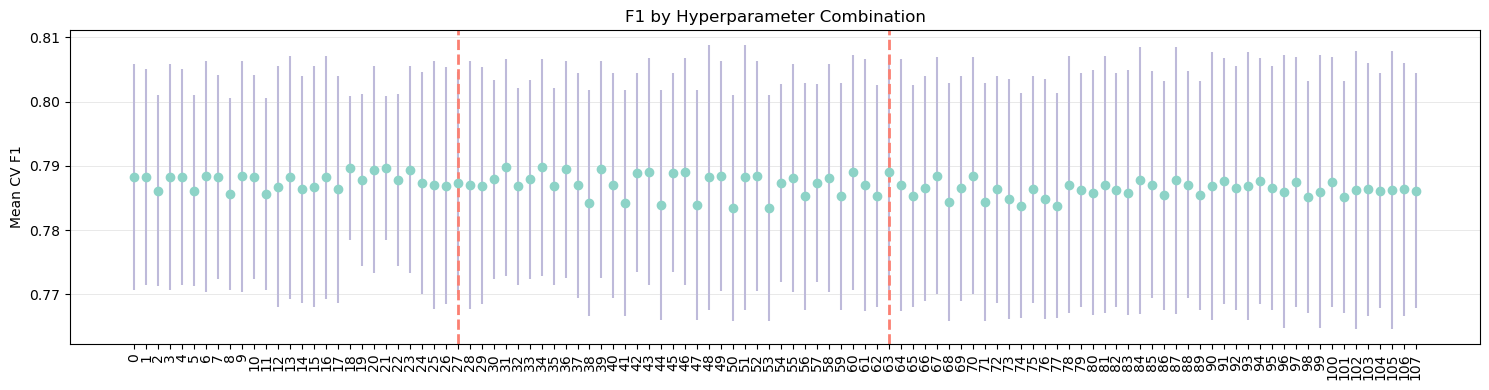

,param_n_estimators,param_max_depth,param_min_samples_split,param_min_samples_leaf,param_ccp_alpha,mean_test_score,std_test_score
34,150,14,3,3,0.030000,0.790,0.017
31,150,14,2,3,0.030000,0.790,0.017


In [12]:
main_color    = '#8DD3C7'  # markers + line caps
errorbar_ec   = '#BEBADA'  # error bars
highlight_col = '#FB8072'  # vertical lines
grid_color    = '#CCCCCC'  # background grid

results = pd.DataFrame(rf_grid.cv_results_)

display_cols = [
    'param_n_estimators',
    'param_max_depth',
    'param_min_samples_split',
    'param_min_samples_leaf',
    'param_ccp_alpha',
    'mean_test_score',
    'std_test_score'
]
sortResults = results[display_cols].sort_values('mean_test_score', ascending=True)

plt.figure(figsize=(15,4))
plt.errorbar(
    color=main_color,
    x=range(len(results)),
    ecolor=errorbar_ec,
    y=results['mean_test_score'],
    yerr=results['std_test_score'],
    fmt='o'
)

plt.axvline(x=27, color=highlight_col, linestyle='--', linewidth=2, label='x=27')
plt.axvline(x=63, color=highlight_col, linestyle='--', linewidth=2, label='x=63')
plt.grid(axis='y', color=grid_color, linestyle='-', linewidth=0.5, alpha=0.6)
plt.xticks(range(len(results)), results.index, rotation=90)
plt.ylabel('Mean CV F1')
plt.title('F1 by Hyperparameter Combination')
plt.tight_layout()
plt.show()

subset = sortResults.iloc[[-1, -2]]

styled = (
    subset.style
          .set_caption("Selected Hyperparameter Combinations")
          .format({
              'mean_test_score': "{:.3f}",
              'std_test_score': "{:.3f}"
          })
)

display(styled)

Combination 27 was selected above since it had the best performance

In [13]:
gb_param_grid = {
    'n_estimators': [125, 150, 175],
    'learning_rate': [.02, .03, .04],
    'max_depth': [2, 3, 4],
    'min_samples_leaf': [2, 3]
}
gb_grid = GridSearchCV(GradientBoostingClassifier(random_state=42), gb_param_grid, cv=cv, scoring='f1', n_jobs=-1)
gb_grid.fit(X_train, y_train)
print("Best Gradient Boosting params:", gb_grid.best_params_)
print("Best Gradient Boosting score:", gb_grid.best_score_)
if gb_grid.best_score_ > best_score:
    best_score = gb_grid.best_score_
    best_model = gb_grid.best_estimator_

Best Gradient Boosting params: {'learning_rate': 0.03, 'max_depth': 3, 'min_samples_leaf': 2, 'n_estimators': 150}
Best Gradient Boosting score: 0.7872993294895055


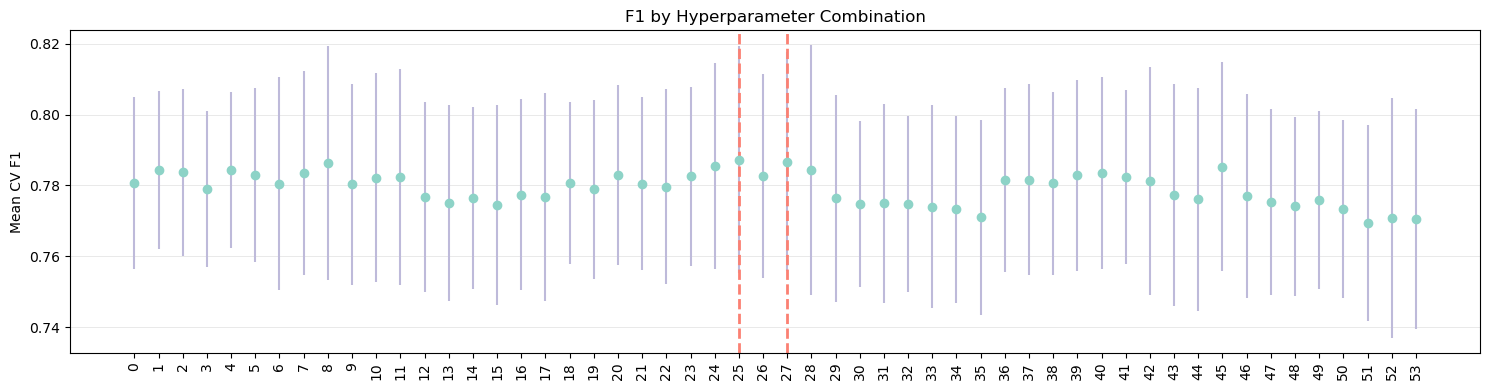

,param_n_estimators,param_max_depth,param_min_samples_leaf,mean_test_score,std_test_score
25,150,3,2,0.787,0.032
27,125,3,3,0.787,0.031


In [14]:
main_color    = '#8DD3C7'  # markers + line caps
errorbar_ec   = '#BEBADA'  # error bars
highlight_col = '#FB8072'  # vertical lines
grid_color    = '#CCCCCC'  # background grid

results = pd.DataFrame(gb_grid.cv_results_)

display_cols = [
    'param_n_estimators',
    'param_max_depth',
    'param_min_samples_leaf',
    'mean_test_score',
    'std_test_score'
]
sortResults = results[display_cols].sort_values('mean_test_score', ascending=True)

plt.figure(figsize=(15,4))
plt.errorbar(
    color=main_color,
    x=range(len(results)),
    ecolor=errorbar_ec,
    y=results['mean_test_score'],
    yerr=results['std_test_score'],
    fmt='o'
)

plt.axvline(x=27, color=highlight_col, linestyle='--', linewidth=2, label='x=27')
plt.axvline(x=25, color=highlight_col, linestyle='--', linewidth=2, label='x=63')
plt.grid(axis='y', color=grid_color, linestyle='-', linewidth=0.5, alpha=0.6)
plt.xticks(range(len(results)), results.index, rotation=90)
plt.ylabel('Mean CV F1')
plt.title('F1 by Hyperparameter Combination')
plt.tight_layout()
plt.show()

subset = sortResults.iloc[[-1, -2]]

styled = (
    subset.style
          .set_caption("Selected Hyperparameter Combinations")
          .format({
              'mean_test_score': "{:.3f}",
              'std_test_score': "{:.3f}"
          })
)

display(styled)

Combination 25 was the best performing combination of the gradient boost. However, this still fell short behind the random forest. 

 &nbsp; &nbsp; &nbsp; &nbsp;We chose to test gradient boosting and random forests for their robust classification properties. We were unsure at the start of what features would be most significant when deciding the outcome of games. So it made sense to use these methods to give equal opportunity to each and avoid the overconfidence that a few might have provided to a more idealistic model. We decided not move forward with a neural network because despite the fact that it likely would haver performed comaprably. The functionality of trees was an intersting topic which we were interested in exploring.

 &nbsp; &nbsp; &nbsp; &nbsp;We chose to use the f1 metric for our results as we believed that it was important to balance our recall and precision. The applications of this software would make it so that negative results in either direction would be unfavorable. Having a static accuracy metric that provided reliability in both directions was what we found to be desirable and attempted to maximize. 

In [28]:
clf = best_model
clf.fit(X_train, y_train)

from sklearn.metrics import classification_report, confusion_matrix

y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

train_acc = accuracy_score(y_train, clf.predict(X_train))
test_acc = accuracy_score(y_test, clf.predict(X_test))

selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X_train, y_train)
f_scores = selector.scores_

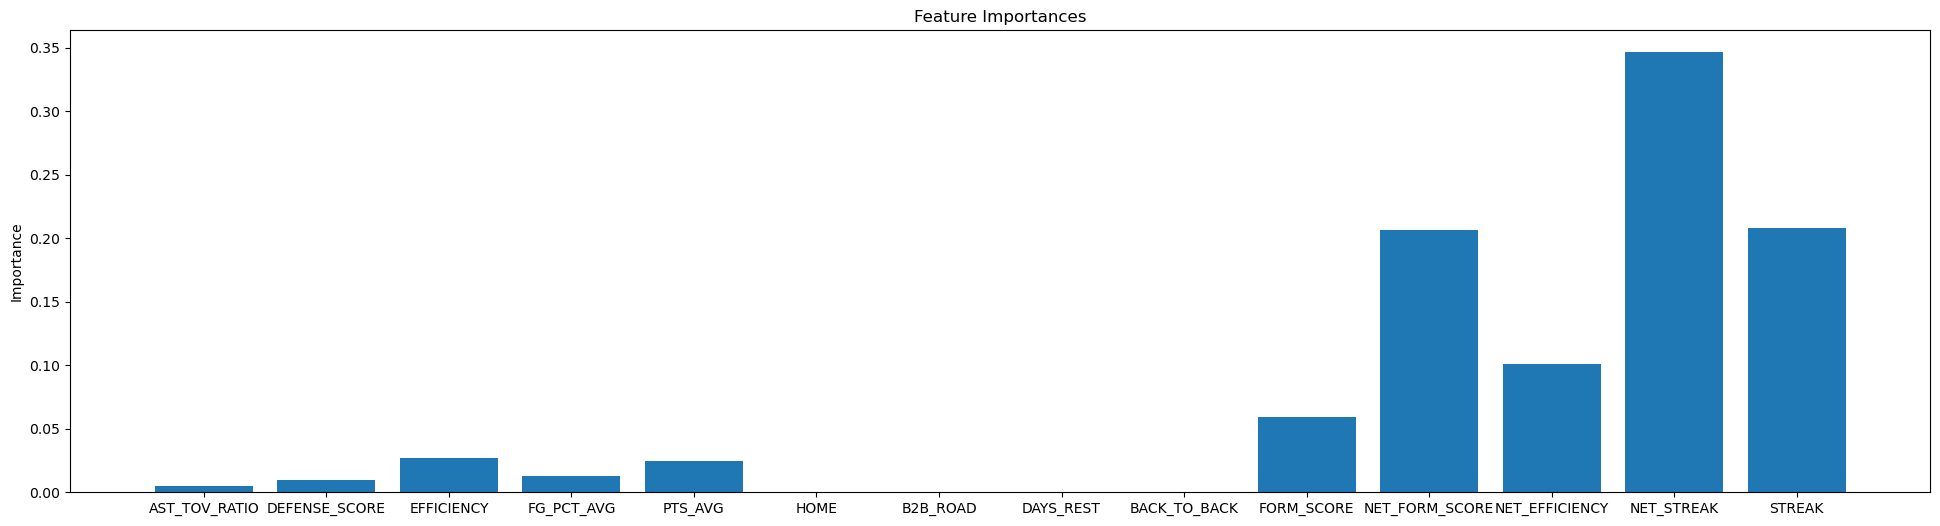

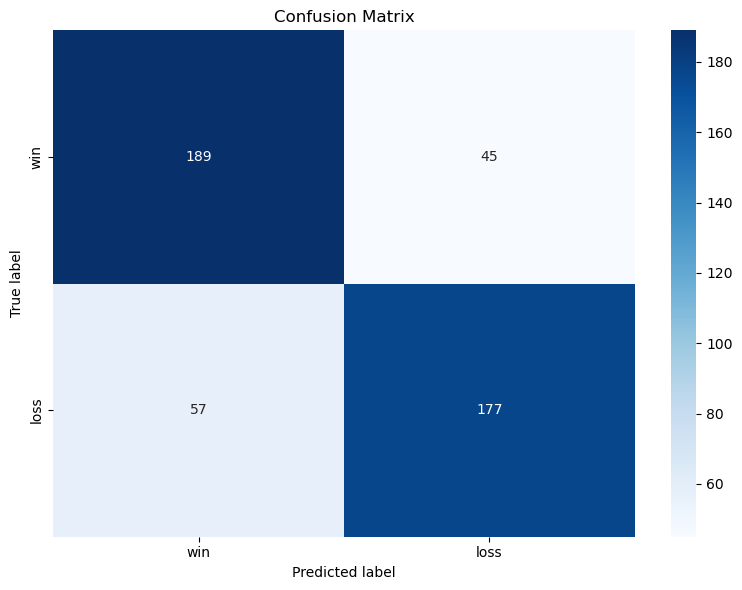

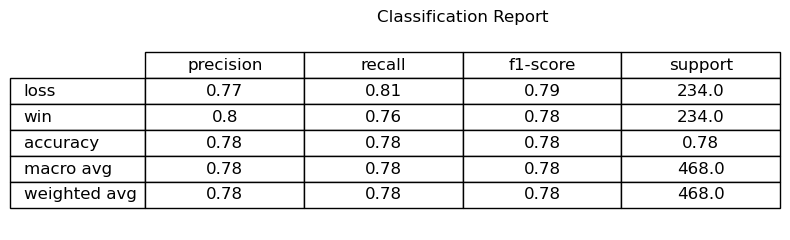

In [18]:
import seaborn as sns

importances = clf.feature_importances_
plt.figure(figsize=(24, 6))
plt.bar(features, importances)
plt.title("Feature Importances")
plt.ylabel("Importance")
plt.show()

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['win', 'loss'],
    yticklabels=['win', 'loss']
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

report_dict = classification_report(y_test, y_pred, output_dict=True)

report_df = pd.DataFrame(report_dict).transpose().round(2)

fig, ax = plt.subplots(figsize=(8, report_df.shape[0] * 0.5))
ax.axis("off")

custom_row_labels = ['loss', 'win'] + list(report_df.index[2:])
tbl = ax.table(
    cellText=report_df.values,
    colLabels=report_df.columns,
    rowLabels=custom_row_labels,
    cellLoc="center",
    loc="center"
)
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
tbl.scale(1, 1.5)
plt.title("Classification Report")
plt.tight_layout()
plt.show()

&nbsp; &nbsp; &nbsp; &nbsp;Our highest performing features turned out to be the streak, form score, and efficiency. As well as the difference between these freatures of the team that was being predicted and their opponents. This data is captured in the net score. We believe this to be a result of the aggregated team data out model was trained on. Without direct access to the players individual scores it was likely difficult to discern meaningful data from the raw performance metrics. Instead the model steered itself towards the overall composite data that would've been a better indicator of how the team did overall, regardless of individual performance and specific shortcommings of an individual lineup. 

&nbsp; &nbsp; &nbsp; &nbsp;The net features are particularly interesting becasuse they represent, over the last five games, how well a given team was matched with their opponents. Which appears to have a strong influence on the models accuracy as without this data it is easily confused. 

&nbsp; &nbsp; &nbsp; &nbsp;Perhaps unsurpriingly the streak score was found to be the most influential and predictive. As teams with a longer hot streak are likely to stay on that hot streak. Additionally teams that play againt an opponent on a hot streak may be more likely to lose. 

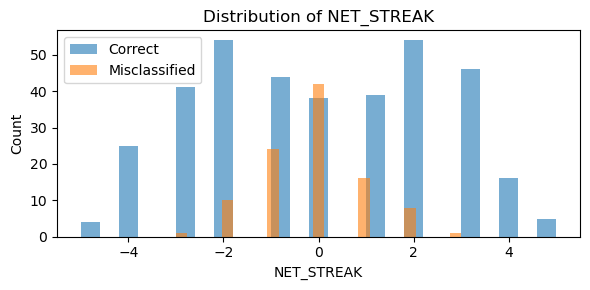

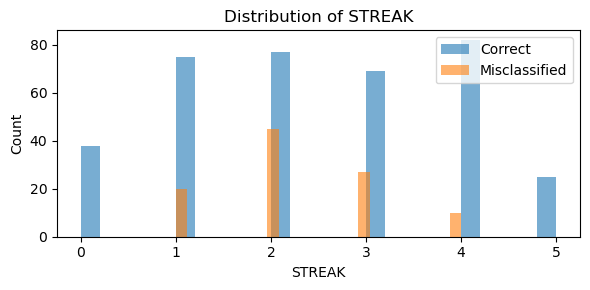

In [35]:
df = X_test.copy()
df['y_true']        = y_test
df['y_pred']        = y_pred
df['misclassified'] = np.logical_xor(df['y_true'], df['y_pred']).astype(int)

for feat in ['NET_STREAK', 'STREAK']:
    ok  = df.loc[df['misclassified'] == 0, feat]
    mis = df.loc[df['misclassified'] == 1, feat]
    
    plt.figure(figsize=(6,3))
    plt.hist(ok,  bins=25, alpha=0.6, label='Correct',   density=False)
    plt.hist(mis, bins=25, alpha=0.6, label='Misclassified', density=False)
    plt.title(f'Distribution of {feat}')
    plt.xlabel(feat)
    plt.ylabel('Count')
    plt.legend()
    plt.tight_layout()
    plt.show()

&nbsp; &nbsp; &nbsp; &nbsp;These graphs show the effect that streak has on the ability for the model to perform. As is show in plot 1, where a net streak of zero represents evenly matched teams, the model is highly likely to misclassify. This is likely due to the aggreagated data not being a strong predictor of outcomes and where the specific player data may be able to compensate. As the individual player matchups could be comapred with limited consideration of how a whole team would match up with another. 

&nbsp; &nbsp; &nbsp; &nbsp;As for graph two we currently dont have a reasonable explanation for why a team on a two game streak would cause the model to missclassify. Speculation points to a high proportion of two game streaks in the data leading to a lack of meanigful prediction on these samples. However, more exploration would be required to confirm. 

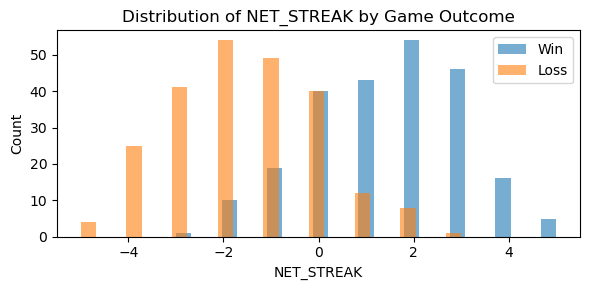

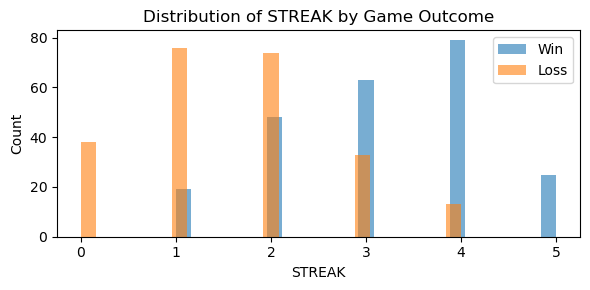

In [36]:
for feat in ['NET_STREAK', 'STREAK']:
    wins  = df.loc[df['y_true'] == 1, feat]
    losses = df.loc[df['y_true'] == 0, feat]
    
    plt.figure(figsize=(6, 3))
    plt.hist(wins,   bins=25, alpha=0.6, label='Win',  density=False)
    plt.hist(losses, bins=25, alpha=0.6, label='Loss', density=False)
    plt.title(f'Distribution of {feat} by Game Outcome')
    plt.xlabel(feat)
    plt.ylabel('Count')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [38]:
import scipy.stats as stats

# Subset to streak == 0
zero_games = df[df['NET_STREAK'] == 0]
wins  = zero_games['y_true'].sum()
n     = len(zero_games)

# Test against a null hypothesis of p=overall_win_rate
p0 = df['y_true'].mean()

# Binomial test (two-sided)
p_value = stats.binomtest(wins, n, p0, alternative='two-sided').pvalue

print(f"Zero-streak games: {n}, wins: {wins}")
print(f"Overall win rate: {p0:.3f}")
print(f"Binomial p-value: {p_value:.3f}")

Zero-streak games: 80, wins: 40
Overall win rate: 0.500
Binomial p-value: 1.000


&nbsp; &nbsp; &nbsp; &nbsp;These plots show the distribution of wins and losses for the net and regular streak features. The distributions clearly show an these features as indicators of success. Although in plot 1, it is very clear why a net_streak of zero leads to missclassfications. There is an equal number of wins and losses atributed to that value. This may look suspicious at first but we believe this to be consistent with the overall win rate. Something that should be expected as zero represents the tipping point between positive and negative momentum in what is otherwise a strongly correlated feature. The binomial test above supports this. It should be noted that an exact split like this is somewhat suspisoucs and likely requires a deeper exploration but is likely a quirk of the data. a consideration for addressing this issue is engineering a new feature that represents this tipping point more accurately or potentially neglecting to include it entirely.  